In [1]:
import sys
import os

print(sys.version)

3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]


In [2]:
# tmp 디렉토리가 없으면 생성합니다.
if not os.path.isdir('tmp'):
    os.mkdir('tmp')
    # Abalone Dataset을 다운로드 받습니다.
    !wget https://archive.ics.uci.edu/static/public/1/abalone.zip -P tmp
    !unzip tmp/abalone.zip

In [3]:
# Abalone 데이터셋으 설명이 들어간 파일을 출력합니다.
!cat tmp/abalone.names

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

# 분석의 목표

Rings를 타겟으로 하는 머신러닝 모델을 만들어 Rings를 예측하는 모델을 만듭니다.

모델의 성능 지표는 RMSLE로 합니다. 

$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$

Kaggle에서도 이 지표를 이용한 Playground 에서 RMSLE를 사용하여 다루었던 주제입니다.

[Kaggle: Regression with an Abalone Dataset](https://www.kaggle.com/competitions/playground-series-s4e4)

여기서는 UCI Repository에서의 데이터만을 가지고, Machine Learning 모델을 만들어 봅니다.

## 실험의 설정

UCI의 abalone 데이터셋의 70%는 학습용, 30%는 평가용 데이터셋으로 만듭니다. 이 때 Rings의 비율이 동일하도록 합니다.

## 노트에서 보일 sgml의 내용

1. 변수의 타입 최적화 합니다.

2. 변수의 처리 내역 및 특성을 데이터프레임으로 관리합니다.

3. 변수의 처리를 위한 탐색적 과정들은 생략합니다.

4. 학습데이터와 평가데이터에 적용할 처리 과정을 list로 정의하여 일괼 처리할 수 있게 합니다.

5. pl.DataFrame에서는 전처리단계에서 사용하고 pd.DataFrame은 Machinne Learning 단계에서 사용합니다. 즉,  pl.DataFrame을 통해 전처리가 끝나면, pd.DataFrame으로 사용합니다.

- 즉, Polars의 데이터 처리의 효율화를 취하고, pd.DataFrame의 타 모듈과 호환성의 장점을 취합니다.

6. sgml에 있는 Tabular 데이터에 특화된 Neural Network 모델을 활용해봅니다.

7. sgml의 SGStacking을 통해 실험 결과를 관리하고 이를 종합하여 stacking 모델을 만듭니다.


## 데이터 처리과정

1. 변수 스펙이 담긴 abalone.names 파일을 기반으로 변수 스펙을 지닌 데이터프레임(df_feature)를 정의합니다. 이 데이터프레임을 통해 변수의 처리 사항이나 특징을 관리합니다.

  - Index는 변수명, Description는 변수에 대한 설명, Unit은 단위, org는 변수의 출처를 나타냅니다.

2. 데이터에 적합한 타입을 파악하기 위해 pl.read_csv → dproc.get_type_df 를 사용하여 변수의 범위와 범주의 수를 파악합니다.

3. dproc.get_type_pl을 이용하여 적합한 변수 타입을 도출합니다.

4. 파악한 변수 타입으로 데이터를 불러 옵니다.

5. functools.partial을 이용하여 dproc의 데이터 처리 함수들에 파라미터를 설정하여 pl.DataFrame을 전달만 하도록 설정 method chaining이 가능한 형태로 데이터를 처리합니다.

- Rings를 log(Rings + 1) 변환을 하여 target 변수를 만듭니다.

- Height 변수에서 이상치들을 범위를 한정 시킵니다.

- 면적(square), 부피(volumn), 밀도(density)를 추가합니다.

- 연속형 입력 변수들 표준화하고 PCA 주성분 4개를 만듭니다.


In [4]:
import dproc
import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [pd, pl, np, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 2.2.2
polars 0.20.24
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2


In [5]:
from functools import partial

# pandas DataFrame에서 텍스트 표시할 때 텍스트 줄임을 하지 않는 최대의 텍스트 길이를 지정합니다.
pd.set_option('display.max_colwidth', 255)

In [6]:
# 변수들에 대한 설명을 담은 데이터프레임입니다. 
# Index는 변수명, Description은 변수에 대한 설명을 나타냅니다. 
df_feature = pd.DataFrame({
    "Description" : [
            "M, F, and I (infant)",
            "Longest shell measurement",
            "perpendicular to length",
            "with meat in shell",
            "whole abalone",
            "weight of meat",
            "gut weight (after bleeding)",
            "after being dried",
            "+1.5 gives the age in years"], 
    "Units": ['', 'mm', 'mm', 'mm', 'grams', 'grams', 'grams', 'grams', '']
    }, index = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
)
df_feature

,Description,Units
Sex,"M, F, and I (infant)",
Length,Longest shell measurement,mm
Diameter,perpendicular to length,mm
Height,with meat in shell,mm
Whole weight,whole abalone,grams
Shucked weight,weight of meat,grams
Viscera weight,gut weight (after bleeding),grams
Shell weight,after being dried,grams
Rings,+1.5 gives the age in years,


In [7]:
# Abalone 데이터셋에 적합한 데이터 타입을 찾기 위한 정보를 가져옵니다.
df_type = pl.read_csv('tmp/abalone.data', has_header=False, new_columns=df_feature.index.tolist()).pipe(
    dproc.get_type_df
)
df_type

,min,max,na,count,n_unique,dtype,f32,i32,i16,i8
feature,,,,,,,,,,
Sex,NaN,NaN,0.0,4177.0,3.0,String,NaN,NaN,NaN,NaN
Length,0.0750,0.8150,0.0,4177.0,134.0,Float64,True,True,True,True
Diameter,0.0550,0.6500,0.0,4177.0,111.0,Float64,True,True,True,True
Height,0.0000,1.1300,0.0,4177.0,51.0,Float64,True,True,True,True
Whole weight,0.0020,2.8255,0.0,4177.0,2429.0,Float64,True,True,True,True
Shucked weight,0.0010,1.4880,0.0,4177.0,1515.0,Float64,True,True,True,True
Viscera weight,0.0005,0.7600,0.0,4177.0,880.0,Float64,True,True,True,True
Shell weight,0.0015,1.0050,0.0,4177.0,926.0,Float64,True,True,True,True
Rings,1.0000,29.0000,0.0,4177.0,28.0,Int64,True,True,True,True


In [8]:
# 병렬화 기능을 가진 polars로 전처리를 합니다.
# Polars를 불러 올 때 사용하기 위한 데이터 타입을 가져옵니다.
pl_dtypes = dproc.get_type_pl(df_type)
pl_dtypes

{'Length': Float32,
 'Diameter': Float32,
 'Height': Float32,
 'Whole weight': Float32,
 'Shucked weight': Float32,
 'Viscera weight': Float32,
 'Shell weight': Float32,
 'Rings': Int8,
 'Sex': Categorical}

In [9]:
# dfl_로 시작하면 pl.DataFrame
dfl_abalone = pl.read_csv('tmp/abalone.data', has_header=False, new_columns=df_feature.index.tolist(), dtypes=pl_dtypes)
dfl_abalone

Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
cat,f32,f32,f32,f32,f32,f32,f32,i8
"""M""",0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
"""M""",0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
"""F""",0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
"""M""",0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10
"""I""",0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7
…,…,…,…,…,…,…,…,…
"""F""",0.565,0.45,0.165,0.887,0.37,0.239,0.249,11
"""M""",0.59,0.44,0.135,0.966,0.439,0.2145,0.2605,10
"""M""",0.6,0.475,0.205,1.176,0.5255,0.2875,0.308,9


In [10]:
# 불러운 데이터 타입을 feature 데이터프레임에 추가 합니다.
# src 컬럼에는 데이터의 출처를 나타내고,
# 원래 데이터가 포함하고 있는 변수들은 org로 나타냅니다.
df_feature = df_feature.join(pd.Series(pl_dtypes, name='type').apply(lambda x: str(x))).assign(
    src = 'org'
)
df_feature

,Description,Units,type,src
Sex,"M, F, and I (infant)",,Categorical,org
Length,Longest shell measurement,mm,Float32,org
Diameter,perpendicular to length,mm,Float32,org
Height,with meat in shell,mm,Float32,org
Whole weight,whole abalone,grams,Float32,org
Shucked weight,weight of meat,grams,Float32,org
Viscera weight,gut weight (after bleeding),grams,Float32,org
Shell weight,after being dried,grams,Float32,org
Rings,+1.5 gives the age in years,,Int8,org


In [11]:
# pl.DataFrame은 sklearn.model_selection train_test_split가 지원하지 않아 수동으로 학습과 평가 데이터를 나눕니다. 
# 0으로 시작하는 데이터의 인덱스 컬럼 no 를 만들고 Rings로 구분하여 no 리스트를 만들고,
# np.random.choice를 이용하여 인덱스를 섞어 줍니다. 
idx = [
    np.random.choice(i, size=len(i), replace=False)
    for i in dfl_abalone.with_columns(pl.int_range(pl.len()).alias('no')).group_by('Rings').agg(pl.col('no'))['no']
]
# 70%는 train의 인덱스로 가져와 모으고, 30%는 평가셋 인덱스로 모읍니다.
# 처음부터 위치 인덱스가 70%인 지점까지 학습셋의 인덱스로 사용합니다.
train_idx = np.hstack([i[:int((np.ceil(len(i) * 0.7)))] for i in idx])
# 이후의 인덱스들은 평가셋으로 사용합니다.
test_idx = np.hstack([i[int((np.ceil(len(i) * 0.7))):] for i in idx])
# 추출한 인덱스로 행들을 선택합니다.
dfl_train = dfl_abalone[train_idx] 
dfl_test = dfl_abalone[test_idx]

In [12]:
display(dfl_train.head())
df_feature

Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
cat,f32,f32,f32,f32,f32,f32,f32,i8
"""M""",0.625,0.495,0.155,1.025,0.46,0.1945,0.34,9
"""M""",0.545,0.41,0.14,0.737,0.349,0.15,0.212,9
"""M""",0.455,0.35,0.105,0.401,0.1575,0.083,0.135,9
"""M""",0.58,0.455,0.17,0.93,0.408,0.259,0.22,9
"""I""",0.41,0.31,0.11,0.315,0.124,0.082,0.095,9


,Description,Units,type,src
Sex,"M, F, and I (infant)",,Categorical,org
Length,Longest shell measurement,mm,Float32,org
Diameter,perpendicular to length,mm,Float32,org
Height,with meat in shell,mm,Float32,org
Whole weight,whole abalone,grams,Float32,org
Shucked weight,weight of meat,grams,Float32,org
Viscera weight,gut weight (after bleeding),grams,Float32,org
Shell weight,after being dried,grams,Float32,org
Rings,+1.5 gives the age in years,,Int8,org


In [13]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Height 의 변수폭을 0.01, 0.025로 한정시킵니다. 이 기준을 도출하기 위한 과정은 생략합니다.
procs = list()
procs.append(
    partial(dproc.with_columns_opr,
        proc_list=[
            ('targetproc', 'target', (pl.col('Rings') + 1).log().cast(pl.Float32), 'RMSLE 지표를 RMSE로 다루어서 분석과정을 보다 간단하게 하기 위한 log1p 변환을 하여 target을 만듭니다.'),
            ('clip_height', 'Height_n', pl.col('Height').clip(0.01, 0.15),  'Height에 이상치로 보이는 값이 있어, 0.01과 0.025 사이의 값으로 한정합니다.')
        ]
    )
)

# with_columns_opr로도 충분히 구현을 할 수 있지만, select_opr을 예시하기 위한 과정을 보입니다.
# 면적, 부피, 밀도 변수를 넣습니다.
procs.append(partial(
    dproc.select_opr, 
    select_proc = lambda x: x.select(
        pl.col('Whole weight'), 
        square = pl.col('Length') * pl.col('Diameter'), 
        volumn = pl.col('Length') * pl.col('Diameter') * pl.col('Height_n')
    ).select(pl.col('square'), pl.col('volumn'), density=pl.col('volumn') / pl.col('Whole weight')),
    desc = [
        ('square', 'Length × Diameter'),
        ('volumn', 'Length × Diameter × Height_n'),
        ('density', 'volumn ÷ Whole Weighht')
    ]
))

# 연속형 입력 변수들을 표준화하고, 표준화된 변수를 주성분을 4개로 뽑도록 PCA 변환을 포함합니다. 
X_std= ['Length', 'Diameter', 'Height_n', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'square', 'volumn', 'density']
X_pca = ['Length', 'Diameter', 'Height_n', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
std_pca = make_pipeline(StandardScaler(), ColumnTransformer([
    ('std', 'passthrough', np.arange(len(X_std))),
    ('pca', PCA(n_components=4), np.arange(len(X_pca)))
]))

# std_pca의 get_feature_names_out()를 통해 처리 후 변수명을 얻을 수 있습니다.
# 이는 {전처리명, 위에서는 std, pca}__{변수명}으로 되어 있습니다.
# 이렇게 전처리명과 변수명 두 개의 항목으로 std_pca에 변수명이 구성되어 있다면, 
# dproc.apply_processor에서는 p에는 전처리명을 v에는 변수명을 넘겨 줍니다.
# info_prov에 전달하는 함수명을 이를 기반으로 변수의 출처정보(org), 설명(Description), 변수 타입을 전달해줍니다.
def std_pca_prov(p, v):
    if p == 'pca':
        # PCA 변환일 경우는 org는 pca, 설명에는 Size Features PCA components v 이고 변수 타입은 pl.Float32로 합니다.
        return ('pca', v, 'Size features PCA component ' + v, pl.Float32)
    return ('std', v, 'StandardScaler: ' + v, pl.Float32)

procs.append(
    partial(dproc.apply_processor, processor = std_pca, X_val = X_std, info_prov = std_pca_prov)
)

ord_enc = OrdinalEncoder(dtype=np.int16, handle_unknown='use_encoded_value', unknown_value=-1)
procs.append(
    partial(dproc.apply_processor, processor = ord_enc, X_val = ['Sex'], info_prov=dproc.ord_prov)
)

In [14]:
# procs할 때 df_feat에 df_feature를 전달하면, processor들은 fit을 하게 되고, 
# 반환되는 df_feature에는 procs에 정의된 변수에 대한 사항이 들어가 있게 됩니다.
dfl_train, df_feature = dproc.apply_procs(dfl_train, procs, df_feat=df_feature)
# procs를 적용할 때 df_feature를 전달하지 않으면, processor들은 transform만 합니다.
dfl_test, _  = dproc.apply_procs(dfl_test, procs)

In [15]:
dfl_train

Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,target,Height_n,square,volumn,density,pca0,pca1,pca2,pca3
i16,f32,f32,f32,f32,f32,f32,f32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
2,0.852675,0.889596,0.155,0.407673,0.460646,0.137439,0.729967,9,2.302585,0.774665,0.903636,0.951476,0.991818,1.602503,-0.503858,0.177749,0.372175
2,0.182817,0.027673,0.14,-0.180955,-0.039164,-0.270875,-0.189449,9,2.302585,0.409319,-0.013179,0.011967,0.534227,-0.036618,-0.536983,-0.144551,0.02536
2,-0.570773,-0.580744,0.105,-0.867687,-0.901448,-0.885639,-0.742535,9,2.302585,-0.869391,-0.69819,-0.89266,0.413271,-2.04079,-0.06419,0.064402,0.371819
2,0.47588,0.483985,0.17,0.213508,0.226501,0.729264,-0.131986,9,2.302585,0.774665,0.41842,0.527716,0.553339,1.035991,-0.463654,-0.414104,-0.247132
1,-0.947569,-0.986355,0.11,-1.043458,-1.052292,-0.894815,-1.029852,9,2.302585,-0.686718,-1.041229,-1.062894,0.847767,-2.517866,-0.195028,-0.028338,-0.099865
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,2.31799,2.258533,0.195,3.475487,2.590467,3.766383,2.741189,23,3.178054,0.774665,2.980276,2.765095,-1.491234,6.836084,1.977363,0.114959,-0.10939
0,0.224683,0.078374,0.135,-0.103288,-0.250795,-0.004783,0.155332,23,3.178054,0.226646,0.038037,-0.017185,0.099492,0.117877,-0.327586,0.218351,0.070512
2,-0.06838,-0.07373,0.16,-0.016425,-0.478186,-0.215822,0.442649,23,3.178054,0.774665,-0.19937,-0.011827,-0.217896,0.110957,-0.709565,0.642405,-0.355696


In [16]:
dfl_train

Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,target,Height_n,square,volumn,density,pca0,pca1,pca2,pca3
i16,f32,f32,f32,f32,f32,f32,f32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32
2,0.852675,0.889596,0.155,0.407673,0.460646,0.137439,0.729967,9,2.302585,0.774665,0.903636,0.951476,0.991818,1.602503,-0.503858,0.177749,0.372175
2,0.182817,0.027673,0.14,-0.180955,-0.039164,-0.270875,-0.189449,9,2.302585,0.409319,-0.013179,0.011967,0.534227,-0.036618,-0.536983,-0.144551,0.02536
2,-0.570773,-0.580744,0.105,-0.867687,-0.901448,-0.885639,-0.742535,9,2.302585,-0.869391,-0.69819,-0.89266,0.413271,-2.04079,-0.06419,0.064402,0.371819
2,0.47588,0.483985,0.17,0.213508,0.226501,0.729264,-0.131986,9,2.302585,0.774665,0.41842,0.527716,0.553339,1.035991,-0.463654,-0.414104,-0.247132
1,-0.947569,-0.986355,0.11,-1.043458,-1.052292,-0.894815,-1.029852,9,2.302585,-0.686718,-1.041229,-1.062894,0.847767,-2.517866,-0.195028,-0.028338,-0.099865
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,2.31799,2.258533,0.195,3.475487,2.590467,3.766383,2.741189,23,3.178054,0.774665,2.980276,2.765095,-1.491234,6.836084,1.977363,0.114959,-0.10939
0,0.224683,0.078374,0.135,-0.103288,-0.250795,-0.004783,0.155332,23,3.178054,0.226646,0.038037,-0.017185,0.099492,0.117877,-0.327586,0.218351,0.070512
2,-0.06838,-0.07373,0.16,-0.016425,-0.478186,-0.215822,0.442649,23,3.178054,0.774665,-0.19937,-0.011827,-0.217896,0.110957,-0.709565,0.642405,-0.355696


In [17]:
# df_feature의 처리 사항을 종합합니다.
df_feature = pd.concat([
    df_feature.groupby(df_feature.index)['Description'].apply(lambda x: ','.join(x)), 
    df_feature.groupby(df_feature.index)['type'].last(),
    df_feature.groupby(df_feature.index)['src'].apply(lambda x: '→'.join(x)),
    df_feature.groupby(df_feature.index)[[i for i in df_feature.columns if i not in ['Description', 'type', 'src']]].last()
], axis=1).sort_index().sort_values('type')
df_feature

,Description,type,src,Units
Diameter,"perpendicular to length,StandardScaler: Diameter",Float32,org→std,mm
square,"Length × Diameter,StandardScaler: square",Float32,square→std,None
pca3,Size features PCA component pca3,Float32,pca,None
pca2,Size features PCA component pca2,Float32,pca,None
pca1,Size features PCA component pca1,Float32,pca,None
pca0,Size features PCA component pca0,Float32,pca,None
density,"volumn ÷ Whole Weighht,StandardScaler: density",Float32,density→std,None
Whole weight,"whole abalone,StandardScaler: Whole weight",Float32,org→std,grams
Viscera weight,"gut weight (after bleeding),StandardScaler: Viscera weight",Float32,org→std,grams
Shucked weight,"weight of meat,StandardScaler: Shucked weight",Float32,org→std,grams


In [18]:
# pd.DataFrame을 사용합니다.
df_train = dfl_train.to_pandas()
del dfl_train
df_test = dfl_test.to_pandas()
del dfl_test

## Machine Learning

1. 연령을 맞추는 회귀 모델이지만,RMSLE 지표 특성상 Rings가 작을 수록 성능에 미치는 영향이 클 뿐만 아니라, Rings가 작은 데이터에는 이상치로 보일 만 관측치의 비중이 큽니다. 

Rings가 정수형 변수라는 점에서 이를 균등하게 하여 보단 균일한 결과가 나오도록 Rings를 기준으로 계층적(Stratified) 교차 검증을 사용합니다.

2. 10-fold를 사용해봅니다.


3. LightGBM, XGBoost, CatBoost, sgnn, LinearRegression 을 Stacking의 기반 모델로 설정합니다.

4. Meta 모델은 Linear Regression을 사용합니다.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import sgnn
import tensorflow as tf

df_train['Rings_cut'] = pd.cut(df_train['Rings'], right=False, bins=[0, 5, 12, np.inf]).cat.codes

2024-05-09 11:36:50.732197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 11:36:51.321445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
import sgml

# 10-fold Stratified Cross Validation으로 설정합니다.
cv10 = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
def predict(m, df_valid, X):
    return pd.Series(m.predict(df_valid[X]), index=df_valid.index)

def eval_metric(df, prds):
    return mean_squared_error(df['target'].sort_index(), prds.sort_index()) ** 0.5

stk = sgml.SGStacking(cv10, predict_func=predict, eval_metric=eval_metric, greater_better=False)

In [21]:
# 학습 결과를 보이기 위한 Helper function입니다. 

# list에 저장된 교차 검증의 결과를 출력합니다.
def print_metrics(valid_metrics, train_metrics):
    print('Valid.: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}'.format( 
        np.mean(valid_metrics), np.std(valid_metrics),
        np.mean(train_metrics), np.std(train_metrics),
    ))
# GB 계열 모델의 교차 검증 결과를 출력합니다.
def show_gb_cv_result(gb_result, train_result, metric='rmse'):
    if train_result is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        df = pd.concat([i[0] for i in train_result], axis=0)[metric].reset_index().rename(columns={'index': 'round'}).groupby('round').mean()
        sns.lineplot(df, ax=axes[0])
    
        sns.barplot(
            pd.concat([i[1] for i in train_result], axis=0).rename('importance').reset_index().rename(columns={'index': 'feature'})\
                .groupby('feature').mean().sort_values('importance', ascending=False),
            x='importance', y='feature', ax=axes[1]
        )
        plt.tight_layout()
        plt.show()
        print_metrics(gb_result['valid_metrics'], gb_result['train_metrics'])
# sgnn의 모델의 학습 결과를 출력합니다.
def show_sgnn_cv_result(sgnn_result, train_result):
    df_sgnn_result = pd.concat([i[0] for i in train_result], axis=0).reset_index().rename(columns={'index': 'epoch'}).groupby('epoch').mean()
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    sns.lineplot(df_sgnn_result[['root_mean_squared_error', 'val_root_mean_squared_error']], ax=axes[0])
    sns.lineplot(df_sgnn_result[['loss', 'val_loss']], ax=axes[1])
    sns.lineplot(df_sgnn_result['learning_rate'], ax=axes[2])
    plt.tight_layout()
    plt.show()
    print_metrics(sgnn_result['valid_metrics'], sgnn_result['train_metrics'])

# Early Stopping 기능을 위한 검증셋을 만들기 위한 함수
def valid_splitter(df):
    return train_test_split(df, train_size=0.9, stratify=df['Rings_cut'], random_state=123)

### LightGBM

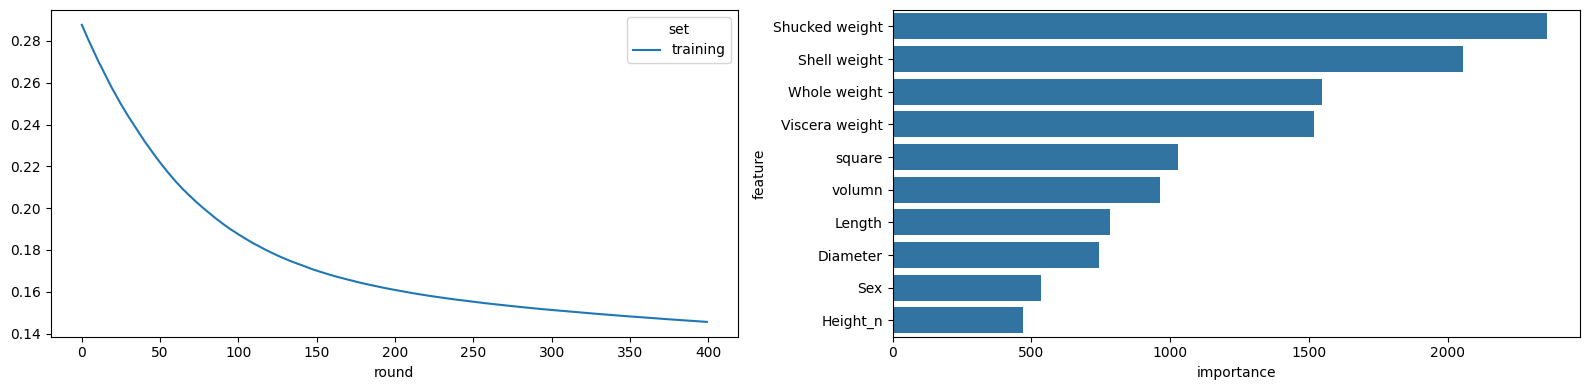

Valid.: 0.17335±0.00865, Train: 0.14560±0.00090


In [22]:
X_lgb_1 = ['Diameter', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'square', 'volumn', 'Sex']
lgb_result, train_result = stk.eval_model(
    'lgb_1', lgb.LGBMRegressor, 
    {'verbose': -1, 'random_state': 123, 'num_leaves': 31, 'n_estimators': 400, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.5, 'subsample_freq': 1, 'reg_lambda':0.001, 'metric': 'rmse'},
    df_train, X_lgb_1, 'target',
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'categorical_feature': ['Sex']},
        'valid_config_proc': sgml.gb_valid_config
    }, sp_y = 'Rings_cut', rerun=True
)
show_gb_cv_result(lgb_result, train_result)

In [23]:
_, train_result, train_metric = stk.select_model(
    'lgb_1', df_train, X_lgb_1, 'target', 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'categorical_feature': ['Sex']},
        'valid_config_proc': sgml.gb_valid_config
    }
)

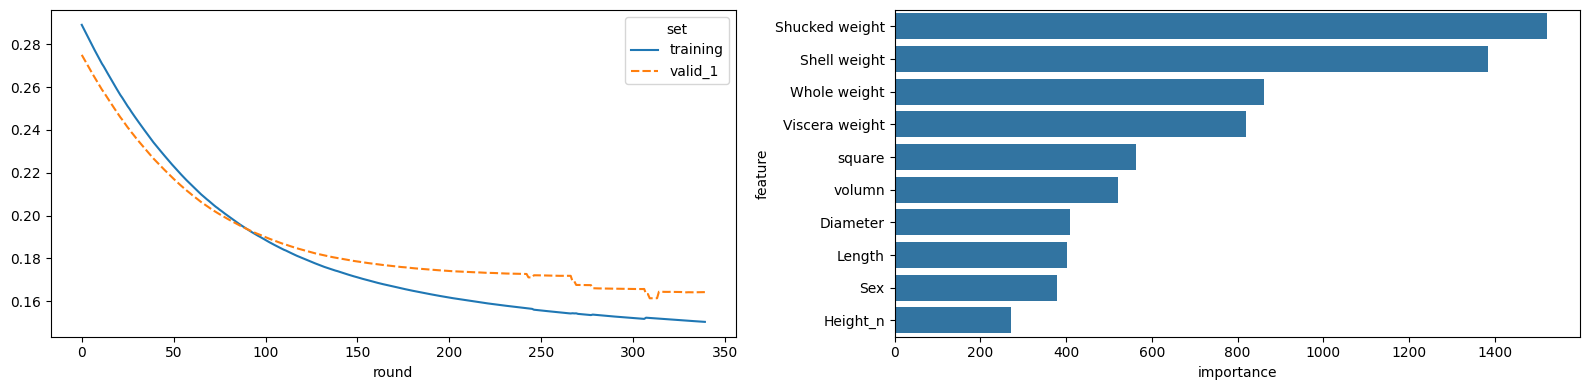

Valid.: 0.17402±0.00796, Train: 0.15612±0.00292


In [24]:
# Early Stopping 사용
X_lgb_2 = ['Diameter', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'square', 'volumn', 'Sex']
lgb_result, train_result = stk.eval_model(
    'lgb_2', lgb.LGBMRegressor, 
    {'verbose': -1, 'random_state': 123, 'num_leaves': 27, 'n_estimators': 1500, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.5, 'subsample_freq': 1, 'metric': 'rmse'},
    df_train, X_lgb_2, 'target',
    result_proc=sgml.lgb_learning_result,
    train_params={
        'valid_splitter': valid_splitter, 
        'fit_params': {'categorical_feature': ['Sex'], 'callbacks': [lgb.early_stopping(10, verbose=False)]}, 
        'valid_config_proc': sgml.gb_valid_config
    }, sp_y = 'Rings_cut'
)
show_gb_cv_result(lgb_result, train_result)

In [25]:
_, train_result, train_metric = stk.select_model(
    'lgb_2', df_train, X_lgb_2, 'target', 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'valid_splitter': valid_splitter, 
        'fit_params': {'categorical_feature': ['Sex'], 'callbacks': [lgb.early_stopping(10, verbose=False)]}, 
        'valid_config_proc': sgml.gb_valid_config
    }
)

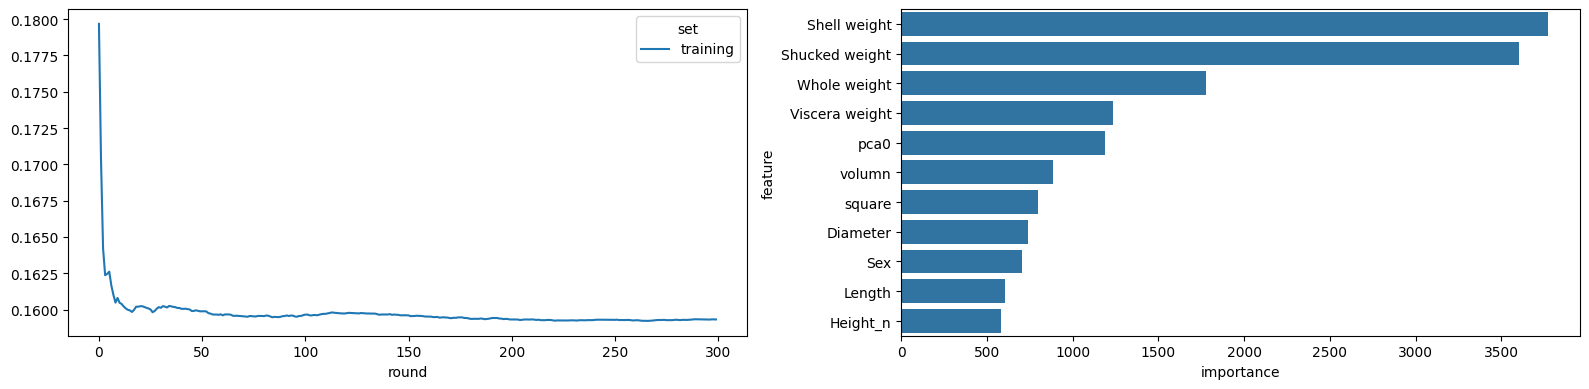

Valid.: 0.17586±0.00838, Train: 0.15932±0.00090


In [26]:
X_lgb_3 = ['Diameter', 'square', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'pca0', 'volumn', 'Sex']
lgb_result, train_result = stk.eval_model(
    'lgb_3', lgb.LGBMRegressor, 
    {'boosting_type': 'rf', 'verbose': -1, 'random_state': 123, 'num_leaves': 54, 'n_estimators': 300, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.75, 'subsample_freq': 1, 'reg_lambda':0.0001, 'metric': 'rmse'},
    df_train, X_lgb_3, 'target',
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'categorical_feature': ['Sex']},
        'valid_config_proc': sgml.gb_valid_config
    }, sp_y = 'Rings_cut'
)
show_gb_cv_result(lgb_result, train_result)

In [27]:
_, train_result, train_metric = stk.select_model(
    'lgb_3', df_train, X_lgb_3, 'target', 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'categorical_feature': ['Sex']},
        'valid_config_proc': sgml.gb_valid_config
    }
)

## XGBoost

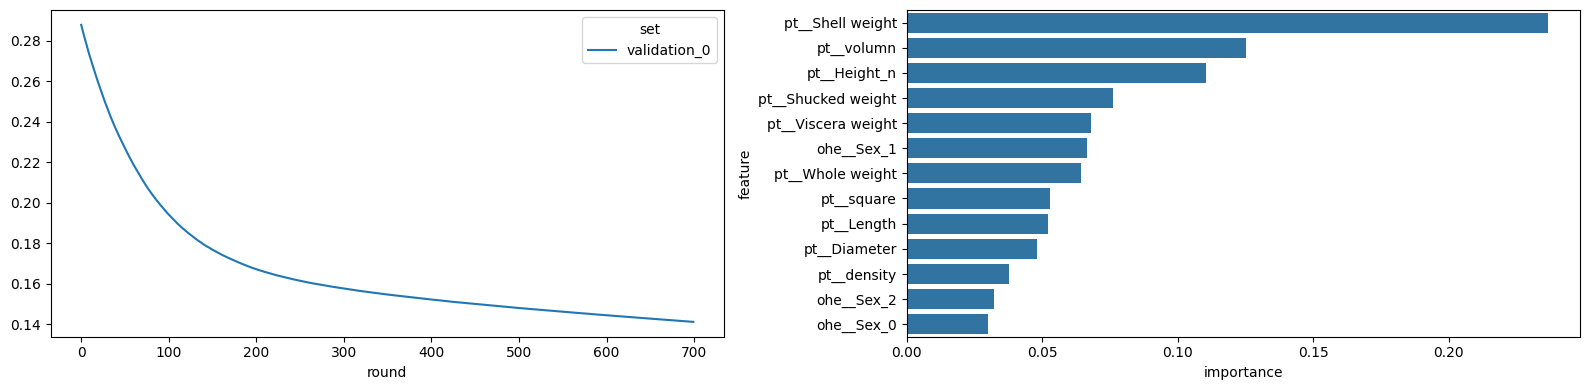

Valid.: 0.17234±0.00886, Train: 0.14110±0.00114


In [28]:
X_xgb_1 = ['Diameter', 'square','density', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'volumn', 'Sex']
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Sex']),
    ('pt', 'passthrough', X_xgb_1[:-1])
])

xgb_result, train_result = stk.eval_model(
    'xgb_1', xgb.XGBRegressor, {'learning_rate': 0.01, 'n_estimators': 700, 'colsample_bytree': 0.9, 'subsample': 0.25, 'max_depth': 5}, 
    df_train, X_xgb_1, 'target', 
    preprocessor = ct,
    result_proc=sgml.xgb_learning_result,
    train_params={
        'fit_params': {'verbose': 0}, 
        'valid_config_proc': sgml.gb_valid_config
    }, sp_y = 'Rings_cut', rerun=True
)
show_gb_cv_result(xgb_result, train_result)

In [29]:
_, train_result, train_metric = stk.select_model(
    'xgb_1', df_train, X_xgb_1, 'target', 
    result_proc=sgml.xgb_learning_result,
    train_params={
        'fit_params': {'verbose': 0}, 
        'valid_config_proc': sgml.gb_valid_config
    }
)

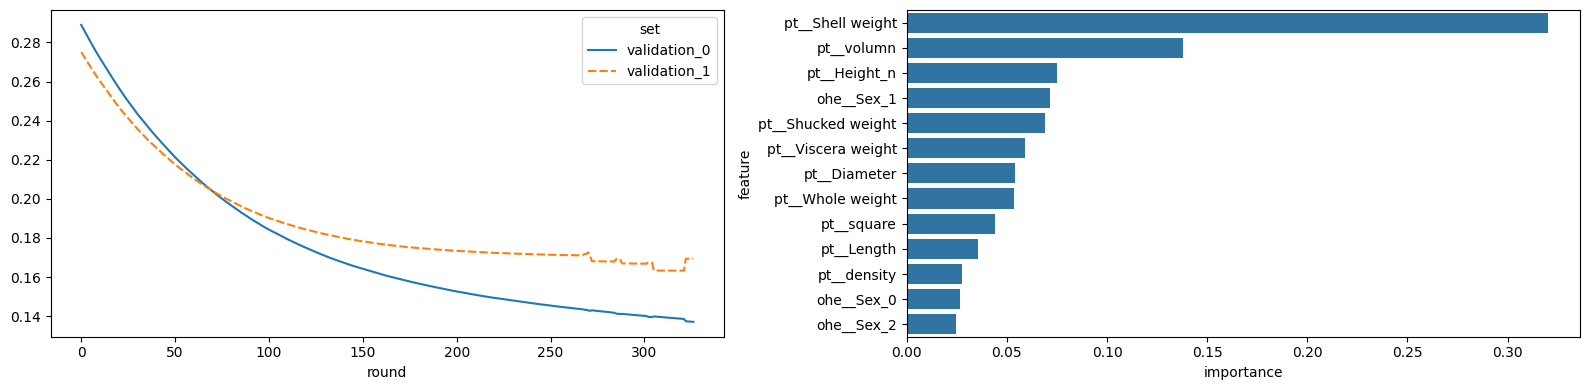

Valid.: 0.17397±0.00796, Train: 0.14544±0.00240


In [30]:
X_xgb_2 = ['Diameter', 'square','density', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'volumn', 'Sex']
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Sex']),
    ('pt', 'passthrough', X_xgb_1[:-1])
])

xgb_result, train_result = stk.eval_model(
    'xgb_2', xgb.XGBRegressor, {'learning_rate': 0.01, 'n_estimators': 700, 'colsample_bytree': 0.9, 'subsample': 0.5, 'max_depth': 6, 'early_stopping_rounds': 10}, 
    df_train, X_xgb_2, 'target', 
    preprocessor = ct,
    result_proc=sgml.xgb_learning_result,
    train_params={
        'valid_splitter': valid_splitter, 
        'fit_params': {'verbose': 0}, 
        'valid_config_proc': sgml.gb_valid_config
    }, sp_y = 'Rings_cut'
)
show_gb_cv_result(xgb_result, train_result)

In [31]:
_, train_result, train_metric = stk.select_model(
    'xgb_2', df_train, X_xgb_2, 'target', 
    preprocessor = ct,
    result_proc=sgml.xgb_learning_result,
    train_params={
        'valid_splitter': valid_splitter, 
        'fit_params': {'verbose': 0}, 
        'valid_config_proc': sgml.gb_valid_config
    }
)

## CatBoost

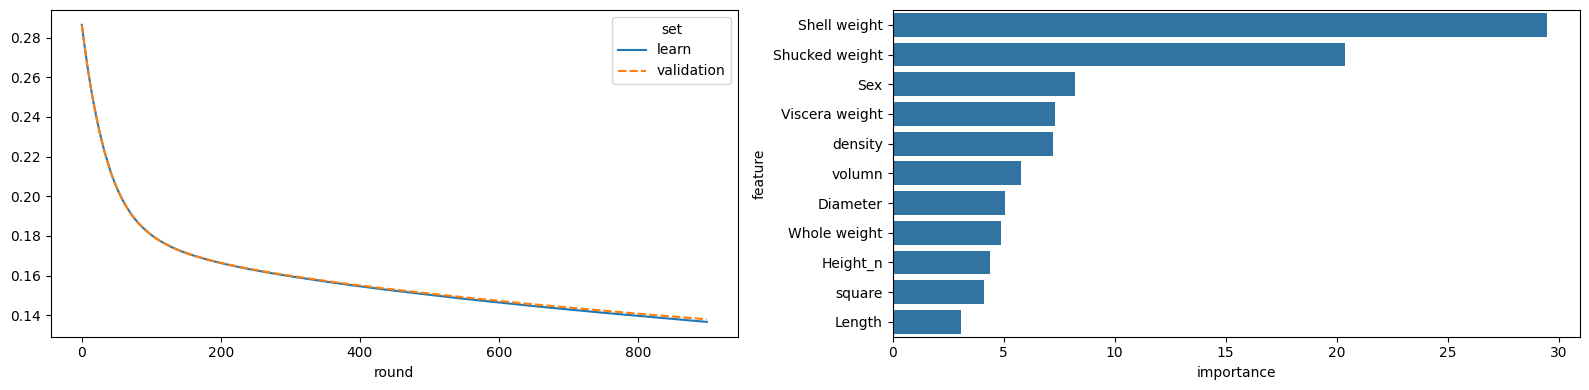

Valid.: 0.17269±0.00861, Train: 0.13789±0.00134


In [32]:
X_cat_1 = ['Diameter', 'square','density', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'volumn', 'Sex']

cb_result, train_result = stk.eval_model(
    'cb_1', cb.CatBoostRegressor, 
    {'grow_policy': 'SymmetricTree', 'learning_rate': 0.02, 'n_estimators': 900, 'colsample_bylevel': 0.5, 'subsample': 0.25, 'max_depth': 8, 'boost_from_average': True, 
     'loss_function': 'RMSE', 'random_strength': 0}, 
    df_train, X_cat_1, 'target', 
    result_proc=sgml.cb_learning_result,
    train_params={
        'valid_config_proc': sgml.gb_valid_config,
        'fit_params': {'verbose': 0, 'cat_features': ['Sex'], }
    }, 
    sp_y = 'Rings_cut'
)
show_gb_cv_result(cb_result, train_result, 'RMSE')

In [33]:
_, train_result, train_metric = stk.select_model(
    'cb_1', df_train, X_cat_1, 'target', 
    result_proc=sgml.cb_learning_result,
    train_params={
        'fit_params': {'verbose': 0, 'cat_features': ['Sex'], },
        'valid_config_proc': sgml.gb_valid_config
    }
)

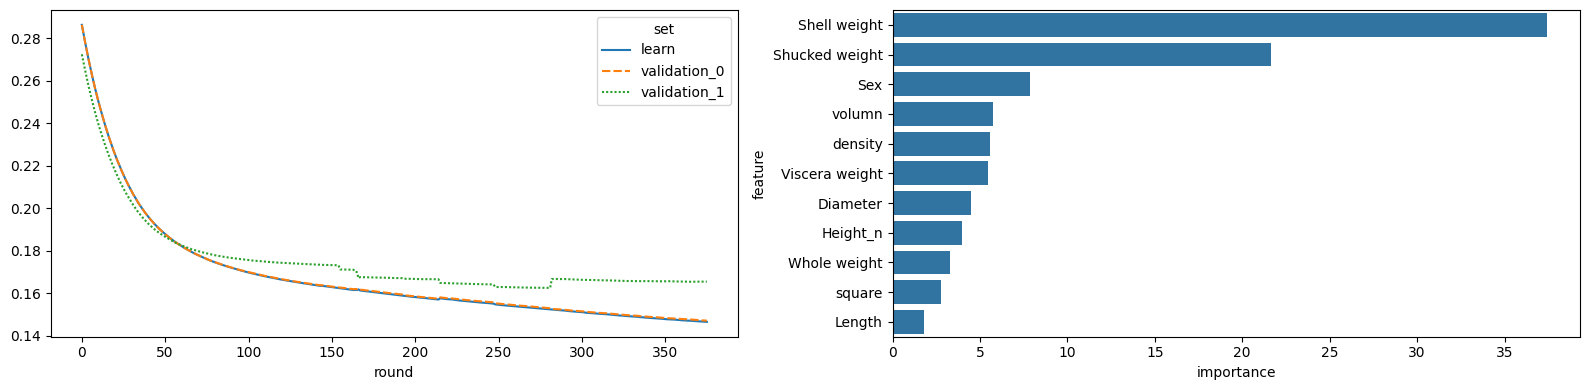

Valid.: 0.17611±0.00820, Train: 0.16040±0.00507


In [34]:
X_cat_2 = ['Diameter', 'square','density', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'volumn', 'Sex']

cb_result, train_result = stk.eval_model(
    'cb_2', cb.CatBoostRegressor, 
    {'grow_policy': 'SymmetricTree', 'learning_rate': 0.03, 'n_estimators': 900, 'colsample_bylevel': 0.75, 'subsample': 0.25, 'max_depth': 8, 'boost_from_average': True, 
     'loss_function': 'RMSE', 'random_strength': 0}, 
    df_train, X_cat_2, 'target', 
    result_proc=sgml.cb_learning_result,
    train_params={
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config,
        'fit_params': {'verbose': 0, 'cat_features': ['Sex'], 'early_stopping_rounds': 10}
    }, 
    sp_y = 'Rings_cut'
)
show_gb_cv_result(cb_result, train_result, 'RMSE')

In [35]:
_, train_result, train_metric = stk.select_model(
    'cb_2', df_train, X_cat_2, 'target', 
    result_proc=sgml.cb_learning_result,
    train_params={
        'valid_splitter': valid_splitter,
        'fit_params': {'verbose': 0, 'cat_features': ['Sex'], },
        'valid_config_proc': sgml.gb_valid_config
    }
)

## SGNN

In [36]:
params = {
    'network_config': [
        {'unit': 32, 'activation': 'relu'},
        {'unit': 16, 'activation': 'relu'},
        {'unit': 8, 'activation': 'relu'},
    ],
    'embedding': [(['Sex'], 3, 2, 0, 0)],
    'batch_size': 128,
    'shuffle_size': 2048000,
    'verbose': 0,
    'learning_rate': 0.01,
    'reduce_lr_on_plateau': {'factor': 0.1, 'patience': 5},
    'early_stopping': {'patience': 10},
    'epochs': 50
}
X_nn_1 = ['Diameter', 'square','density', 'Whole weight', 'Viscera weight', 'Shucked weight', 'Shell weight', 'Length', 'Height_n', 'volumn', 'Sex']
sgnn_result, train_result = stk.eval_model(
    'sgnn_1', sgnn.NNRegressor, params, df_train, X_nn_1, 'target', 
    result_proc=sgml.sgnn_learning_result,
    train_params={
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.sgnn_valid_config,
        'fit_params': {'metrics': [tf.keras.metrics.RootMeanSquaredError()]}
    }, 
    sp_y = 'Rings_cut'
)

2024-05-09 11:37:34.172520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 11:37:34.196398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 11:37:34.196561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [37]:
_, train_result, train_metric = stk.select_model(
    'sgnn_1', df_train, X_nn_1, 'target', 
    result_proc=sgml.sgnn_learning_result,
    train_params={
        'valid_splitter': valid_splitter,
        'fit_params': {'metrics': [tf.keras.metrics.RootMeanSquaredError()]},
        'valid_config_proc': sgml.sgnn_valid_config
    }
)

In [38]:
stk.get_best_results(['lgb_1', 'lgb_2', 'lgb_3', 'xgb_1', 'xgb_2', 'cb_1', 'cb_2', 'sgnn_1'])

,model,model_params,X,train_metrics,valid_metrics
0,LGBMRegressor,"{'verbose': -1, 'random_state': 123, 'num_leaves': 31, 'n_estimators': 400, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.5, 'subsample_freq': 1, 'reg_lambda': 0.001, 'metric': 'rmse'}","Diameter,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,square,volumn,Sex",0.14560±0.00090,0.17335±0.00865
1,LGBMRegressor,"{'verbose': -1, 'random_state': 123, 'num_leaves': 27, 'n_estimators': 1500, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.5, 'subsample_freq': 1, 'metric': 'rmse'}","Diameter,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,square,volumn,Sex",0.15612±0.00292,0.17402±0.00796
2,LGBMRegressor,"{'boosting_type': 'rf', 'verbose': -1, 'random_state': 123, 'num_leaves': 54, 'n_estimators': 300, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.75, 'subsample_freq': 1, 'reg_lambda': 0.0001, 'metric': 'rmse'}","Diameter,square,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,pca0,volumn,Sex",0.15932±0.00090,0.17586±0.00838
3,XGBRegressor,"{'learning_rate': 0.01, 'n_estimators': 700, 'colsample_bytree': 0.9, 'subsample': 0.25, 'max_depth': 5}","Diameter,square,density,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,volumn,Sex",0.14110±0.00114,0.17234±0.00886
4,XGBRegressor,"{'learning_rate': 0.01, 'n_estimators': 700, 'colsample_bytree': 0.9, 'subsample': 0.5, 'max_depth': 6, 'early_stopping_rounds': 10}","Diameter,square,density,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,volumn,Sex",0.14544±0.00240,0.17397±0.00796
5,CatBoostRegressor,"{'grow_policy': 'SymmetricTree', 'learning_rate': 0.02, 'n_estimators': 900, 'colsample_bylevel': 0.5, 'subsample': 0.25, 'max_depth': 8, 'boost_from_average': True, 'loss_function': 'RMSE', 'random_strength': 0}","Diameter,square,density,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,volumn,Sex",0.13789±0.00134,0.17269±0.00861
6,CatBoostRegressor,"{'grow_policy': 'SymmetricTree', 'learning_rate': 0.03, 'n_estimators': 900, 'colsample_bylevel': 0.75, 'subsample': 0.25, 'max_depth': 8, 'boost_from_average': True, 'loss_function': 'RMSE', 'random_strength': 0}","Diameter,square,density,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,volumn,Sex",0.16040±0.00507,0.17611±0.00820
7,NNRegressor,"{'network_config': [{'unit': 32, 'activation': 'relu'}, {'unit': 16, 'activation': 'relu'}, {'unit': 8, 'activation': 'relu'}], 'embedding': [(['Sex'], 3, 2, 0, 0)], 'batch_size': 128, 'shuffle_size': 2048000, 'verbose': 0, 'learning_rate': 0.01, 'red...","Diameter,square,density,Whole weight,Viscera weight,Shucked weight,Shell weight,Length,Height_n,volumn,Sex",0.16977±0.00151,0.17790±0.01063


In [39]:
from sklearn.linear_model import LinearRegression
valid_metrics, train_metrics, _ = stk.eval_meta_model(
    LinearRegression, {},  ['lgb_1', 'lgb_2', 'lgb_3', 'xgb_1', 'xgb_2', 'cb_1', 'cb_2', 'sgnn_1'], 
    df_train[['target', 'Rings_cut']], 'target', sp_y='Rings_cut'
)
print_metrics(valid_metrics, train_metrics)

Valid.: 0.17084±0.00098, Train: 0.17129±0.00894


In [40]:
stk.fit(LinearRegression, {},  ['lgb_1', 'lgb_2', 'lgb_3', 'xgb_1', 'xgb_2', 'cb_1', 'cb_2', 'sgnn_1'], df_train, 'target')

{'variables': ['lgb_1',
  'lgb_2',
  'lgb_3',
  'xgb_1',
  'xgb_2',
  'cb_1',
  'cb_2',
  'sgnn_1'],
 'train_shape': (2937, 8),
 'target': 'target'}

In [41]:
from sklearn.metrics import mean_squared_error
mean_squared_error(
    df_test['target'], stk.predict(df_test)
) ** 0.5

0.1628197483231782